In [62]:
import os
from nntools.dataset import SegmentationDataset
import pandas as pd
import cv2
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [87]:
root = 'MessidorAnnotation/'
df = pd.read_excel(root+'agreement_diagnosis.xls')
df = df.drop(axis=0, index=[0,1])
dr_grades = df['Majority Voting'].tolist()
imgs_name = df['img_name'].tolist()
me_grades = df['Unnamed: 12'].tolist()

def get_hem(root, name):
    root_red = os.path.join(root, 'biomarkers', 'Red')
    name = name+'.png'
    he = cv2.imread(os.path.join(root_red, 'Hemorrhages', name), cv2.IMREAD_GRAYSCALE)
    prehe = cv2.imread(os.path.join(root_red, 'Pre-retinal hemorrhage', name), cv2.IMREAD_GRAYSCALE)
    subhe = cv2.imread(os.path.join(root_red, 'Sub-retinal hemorrhage', name), cv2.IMREAD_GRAYSCALE)
    return np.logical_or(np.logical_or(he, prehe), subhe)

def get_ma(root, name):
    root_red = os.path.join(root, 'biomarkers', 'Red')
    name = name+'.png'
    ma = cv2.imread(os.path.join(root_red, 'Microaneurysms', name), cv2.IMREAD_GRAYSCALE)
    return ma>0

def get_neovas(root, name):
    root_red = os.path.join(root, 'biomarkers', 'Red')
    name = name+'.png'
    nv = cv2.imread(os.path.join(root_red, 'Neovascularization', name), cv2.IMREAD_GRAYSCALE)
    return nv>0
def get_drusen(root, name):
    root_bright = os.path.join(root, 'biomarkers', 'Bright')
    name = name+'.png'
    drusen = cv2.imread(os.path.join(root_bright, 'Drusen', name), cv2.IMREAD_GRAYSCALE)
    return drusen>0
def get_ex(root, name):
    root_bright = os.path.join(root, 'biomarkers', 'Bright')
    name = name+'.png'
    ex = cv2.imread(os.path.join(root_bright, 'Exudates', name), cv2.IMREAD_GRAYSCALE)
    return ex>0
def get_cws(root, name):
    root_bright = os.path.join(root, 'biomarkers', 'Bright')
    name = name+'.png'
    cws = cv2.imread(os.path.join(root_bright, 'Cotton Wool Spots', name), cv2.IMREAD_GRAYSCALE)
    return cws>0
def get_macula(root, name):
    root_macula = os.path.join(root, 'biomarkers', 'Normal', 'Macula')
    name = name+'.png'
    mac = cv2.imread(os.path.join(root_macula, name), cv2.IMREAD_GRAYSCALE)
    return mac>0
def get_OD(root, name):
    root_disk = os.path.join(root, 'biomarkers', 'Normal', 'Disk')
    name = name+'.png'
    disk = cv2.imread(os.path.join(root_disk, name), cv2.IMREAD_GRAYSCALE)
    return disk>0
def get_vessels(root, name):
    root_disk = os.path.join(root, 'biomarkers', 'Vessels','Vessels - Uncertain')
    name = name+'.png'
    vessels = cv2.imread(os.path.join(root_disk, name), cv2.IMREAD_GRAYSCALE)
    return vessels>0

In [37]:
all_lesions_maps = []
labels_distribution = []
for name in tqdm(imgs_name):
    he = get_hem(root, name)
    ex = get_ex(root, name)
    cws = get_cws(root, name)
    ma = get_ma(root, name)
    drusen = get_drusen(root, name)
    neo = get_neovas(root, name)
    lesions_map = np.zeros_like(he, dtype=np.uint8)
    lesions_map[ex] = 1
    lesions_map[he] = 2
    lesions_map[ma] = 3
    lesions_map[cws] = 4
    lesions_map[drusen] = 5
    lesions_map[neo] = 6
    all_lesions_maps.append(lesions_map)
    hist, bin_edges = np.histogram(lesions_map, bins=7, range=[0, 7], density=False)
    labels_distribution.append(hist[1:]>0)



  0%|          | 0/200 [00:00<?, ?it/s]

In [39]:
l_distributions = np.stack(labels_distribution)

In [51]:
from sklearn.model_selection import train_test_split
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
mss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
split = mss.split(imgs_name, l_distributions)
train, test = next(split)

In [105]:

def save_image(output_folder, folder, name, img):
    out_folder = os.path.join(output_folder, folder)
    name = name+'.png'
    if not os.path.exists(out_folder):
        os.makedirs(out_folder)
    outpath = os.path.join(out_folder, name)
    if img.dtype==bool:
        img = img.astype(np.uint8)*255
    cv2.imwrite(outpath, img)
    
def save_folder(output_folder, list_images):
    for name in tqdm(list_images):
        imgpath = os.path.join(root, 'img', 'images', name+'.png')
        img = cv2.imread(imgpath)
        save_image(output_folder, 'Images', name, img)
        
        mac = get_macula(root, name)
        save_image(output_folder, 'Macula', name, mac)
        od = get_OD(root, name)
        save_image(output_folder, 'OpticDisk', name, od)
        vessels = get_vessels(root, name)
        save_image(output_folder, 'Vessels', name, vessels)
        others = np.zeros_like(mac, dtype=np.uint8)
        others[od] = 1
        others[mac] = 2
        others[vessels] = 3
        save_image(output_folder, 'Normals', name, others)

        
        he = get_hem(root, name)
        save_image(output_folder, 'Hemorrhages', name, he)
        ex = get_ex(root, name)
        save_image(output_folder, 'Exudates', name, ex)
        cws = get_cws(root, name)
        save_image(output_folder, 'CottonWoolSpot', name, cws)
        ma = get_ma(root, name)
        save_image(output_folder, 'Microaneurysms', name, ma)
        drusen = get_drusen(root, name)
        save_image(output_folder, 'Drusen', name, drusen)
        neo = get_neovas(root, name)
        save_image(output_folder, 'Neovascularization', name, neo)
        lesions_map = np.zeros_like(he, dtype=np.uint8)
        lesions_map[ex] = 1
        lesions_map[he] = 2
        lesions_map[ma] = 3
        lesions_map[cws] = 4
        lesions_map[drusen] = 5
        lesions_map[neo] = 6
        save_image(output_folder, 'Lesions', name, lesions_map)
        all_labels = lesions_map*(lesions_map>0) + (1-(lesions_map>0))*(others>0)*(others+6)
        save_image(output_folder, 'AllLabels', name, all_labels)

In [106]:
imgs_name = np.asarray(imgs_name)
train_imgs = imgs_name[train]
save_folder('database_clean/train/', train_imgs)
test_imgs = imgs_name[test]
save_folder('database_clean/test/', test_imgs)

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

/home/clement/Documents/phd/NNTools/src/nntools/utils/plotting.py:151: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


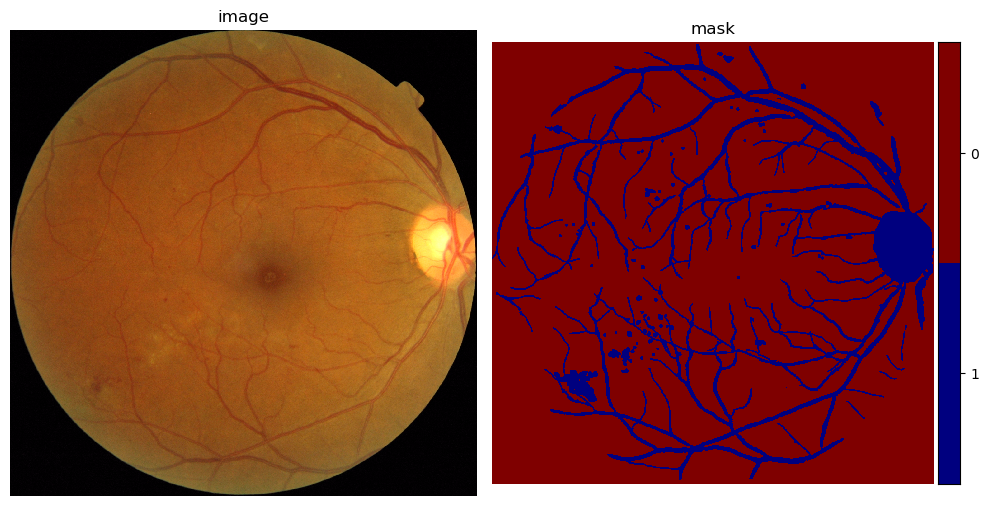